# Module 0.3: Bloch Vector

This notebook is part of the Qiskit v2.x Study Guide.  It introduces Bloch
vectors, shows how to reason about rotations, and demonstrates how to plot Bloch
vectors in Qiskit.  The material aligns with the exam objectives for visualizing
quantum states.  See Module 2.3 for more state-visualization options.  

**Topics covered**
- Review of rotation matrices about $x$, $y$, and $z$ axes.  
- Bloch vector basics and coordinate conventions.  
- Plotting Bloch vectors with Qiskit.  
- Predicting results of tensor-product operations using Bloch-sphere reasoning.  
- Implementing the examples in Qiskit and verifying with plots.  

**Documentation and resources**
- Qiskit API: `plot_bloch_vector`  
  https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.visualization.plot_bloch_vector  
- Interactive Bloch sphere (helpful intuition):  
  https://javafxpert.github.io/grok-bloch/  
- More state visualization tools appear in **Module 2.3**.  


In [2]:
# Metadata cell: versions and minimal imports
import sys, platform
print("Python:", sys.version.split()[0])
try:
    import qiskit
    print("Qiskit:", qiskit.__version__)
except Exception as exc:
    print("Qiskit: <not installed in this environment>")
    print("Note: Run this notebook where Qiskit v2.x is available.")

# Core imports (kept concise)
from qiskit import transpile
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qiskit.visualization import plot_bloch_vector
import numpy as np

# Fake backend (no real QPUs used)
try:
    from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
    _fake_backend = FakeSherbrooke()
    print("Fake backend:", _fake_backend.name)
except Exception as exc:
    _fake_backend = None
    print("Fake backend unavailable in this environment.")


Python: 3.12.9
Qiskit: 2.2.1
Fake backend: fake_sherbrooke


![Bloch sphere diagram](Bloch_sphere.svg.png)


## Section 0.3.0 Review: Rotation Matrices

A single-qubit pure state can be represented by a point on the Bloch sphere.
Unitary rotations move the Bloch vector on the sphere without changing its norm.  

The standard rotation gates about principal axes are:  

$$
R_x(\theta) = e^{-i\,\theta X/2}
= \begin{pmatrix}
\cos(\tfrac{\theta}{2}) & -i\sin(\tfrac{\theta}{2}) \\
-i\sin(\tfrac{\theta}{2}) & \cos(\tfrac{\theta}{2})
\end{pmatrix},
\quad
R_y(\theta) = e^{-i\,\theta Y/2}
= \begin{pmatrix}
\cos(\tfrac{\theta}{2}) & -\sin(\tfrac{\theta}{2}) \\
\sin(\tfrac{\theta}{2}) & \cos(\tfrac{\theta}{2})
\end{pmatrix},
$$

$$
R_z(\theta) = e^{-i\,\theta Z/2}
= \begin{pmatrix}
e^{-i\theta/2} & 0 \\ 0 & e^{i\theta/2}
\end{pmatrix}.
$$

On the Bloch vector $\vec{r}=(x,y,z)$, a rotation $R_a(\theta)$ about axis
$a\in\{x,y,z\}$ by angle $\theta$ transforms $\vec{r}$ by the corresponding
SO(3) rotation.  For example, a $z$-rotation acts as  
$x' = x\cos\theta - y\sin\theta$, $y' = x\sin\theta + y\cos\theta$,
$z' = z$.  

Conventions used here: $|0\rangle$ maps to $(0,0,1)$, $|1\rangle$ to $(0,0,-1)$,
$|+\rangle$ to $(1,0,0)$, $|-\rangle$ to $(-1,0,0)$, $|+i\rangle$ to $(0,1,0)$,
and $|-i\rangle$ to $(0,-1,0)$.  


## Section 0.3.1 Bloch vector concepts  

**Goals.** Understand how $(x,y,z)$ relate to angles $\theta$ and $\phi$, how the  
right-hand rule sets axes and rotation sign, and how to write $|\psi\rangle$ in the  
computational basis.  

**Bloch coordinates.** For a pure one-qubit state described by polar angles  
$\theta \in [0,\pi]$ and $\phi \in [0,2\pi)$ on the Bloch sphere, the Cartesian  
components are  
$$x = \sin\theta\,\cos\phi,\quad y = \sin\theta\,\sin\phi,\quad z = \cos\theta.$$  
These satisfy $x^2 + y^2 + z^2 = 1$ for pure states.  Which means that pure states are on the surface of the sphere.

**Right-hand rule.** The Bloch sphere uses a right-handed coordinate system. Point  
your right-hand thumb along $+\hat{z}$; curling fingers from $+\hat{x}$ toward  
$+\hat{y}$ shows the positive rotation sense about $+\hat{z}$. By convention,  
$|0\rangle$ is at the north pole $(0,0,1)$ and $|1\rangle$ at the south pole  
$(0,0,-1)$.  

**Computational-basis form.** Any normalized single-qubit pure state can be written  
as  
$$|\psi(\theta,\phi)\rangle = \cos\tfrac{\theta}{2}\,|0\rangle \, + \, e^{i\phi}  
\,\sin\tfrac{\theta}{2}\,|1\rangle,$$  
with global phase omitted. This parameterization maps to $(x,y,z)$ via the formulas  
above.  

*Quick check.* The code below computes $(x,y,z)$ from $(\theta,\phi)$ and verifies  
it by extracting the Bloch components from the corresponding density matrix.  


In [2]:
# Compute Bloch vector from (theta, phi) and verify via density matrix.
import numpy as np
from qiskit.quantum_info import Statevector, DensityMatrix

def bloch_from_angles(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return np.array([x, y, z])

# Example values (reproducible, deterministic)
theta = np.pi / 3   # 60 degrees
phi = np.pi / 4     # 45 degrees

# State: cos(theta/2)|0> + e^{i phi} sin(theta/2)|1>
state = np.array([np.cos(theta/2), np.exp(1j*phi)*np.sin(theta/2)], dtype=complex)
sv = Statevector(state)
rho = DensityMatrix(sv).data

# Pauli expectation values r_i = Tr(rho * sigma_i)
pauli_x = np.array([[0,1],[1,0]], dtype=complex)
pauli_y = np.array([[0,-1j],[1j,0]], dtype=complex)
pauli_z = np.array([[1,0],[0,-1]], dtype=complex)

r = np.array([np.trace(rho @ pauli_x).real,
              np.trace(rho @ pauli_y).real,
              np.trace(rho @ pauli_z).real])

print("Angles (theta, phi):", (theta, phi))
print("Analytic  (x,y,z):  ", bloch_from_angles(theta, phi))
print("From state (x,y,z): ", r)


Angles (theta, phi): (1.0471975511965976, 0.7853981633974483)
Analytic  (x,y,z):   [0.61237244 0.61237244 0.5       ]
From state (x,y,z):  [0.61237244 0.61237244 0.5       ]


## Section 0.3.2 Bloch Vector in Qiskit

We use `qiskit.visualization.plot_bloch_vector` to plot a vector
$\vec{r}=[x,y,z]$ with $\lVert\vec{r}\rVert\le 1$.  This is convenient for
visualizing ideal pure states and mixed states (reduced single-qubit states).  

Below are a few basic examples that reproduce known axes states.  


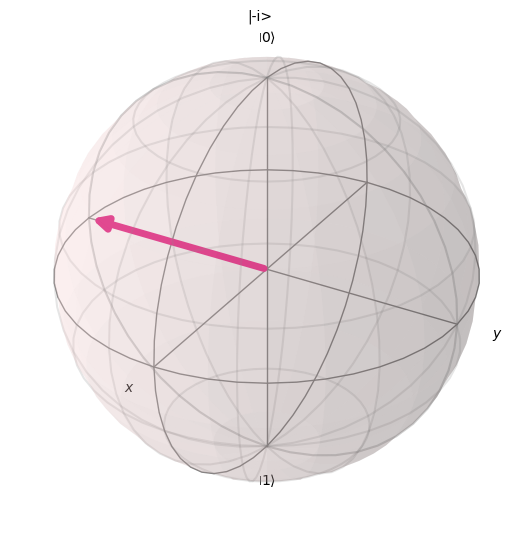

In [3]:
# 0.3.1 — Basic Bloch vectors
from qiskit.visualization import plot_bloch_vector

# |0>  -> (0, 0, 1)
plot_bloch_vector([0, 0, 1], title="|0>")

# |1>  -> (0, 0, -1)
plot_bloch_vector([0, 0, -1], title="|1>")

# |+>  -> (1, 0, 0)
plot_bloch_vector([1, 0, 0], title="|+>")

# |->  -> (-1, 0, 0)
plot_bloch_vector([-1, 0, 0], title="|->")

# |+i> -> (0, 1, 0)
plot_bloch_vector([0, 1, 0], title="|+i>")

# |-i> -> (0, -1, 0)
plot_bloch_vector([0, -1, 0], title="|-i>")


## Section 0.3.3 — From a circuit to a Bloch vector (single-qubit case)

Bloch vector ≈ [-0. -1.  0.]


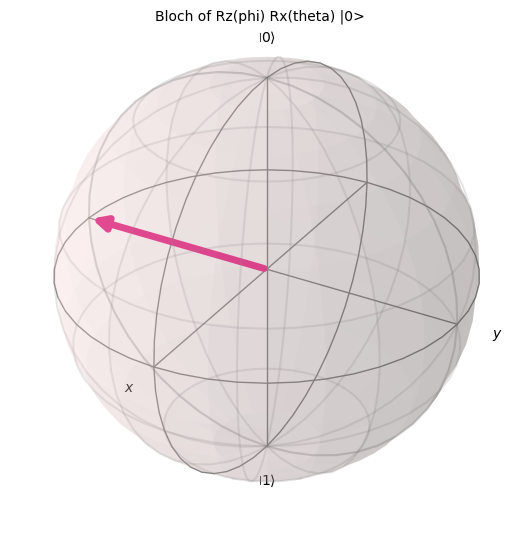

In [4]:

# We prepare Rz(phi) Rx(theta) |0> and plot its Bloch vector.
phi = np.pi/3
theta = np.pi/2

qc = QuantumCircuit(1, name="RzRx|0>")
qc.rz(phi, 0)
qc.rx(theta, 0)

# Ideal state and Bloch vector via Pauli expectations
psi = Statevector.from_instruction(qc)
rho = DensityMatrix(psi)

X = np.array([[0,1],[1,0]], dtype=complex)
Y = np.array([[0,-1j],[1j,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)
bloch = [np.trace(rho.data @ X).real,
         np.trace(rho.data @ Y).real,
         np.trace(rho.data @ Z).real]

print("Bloch vector ≈", np.round(bloch, 6))
plot_bloch_vector(bloch, title="Bloch of Rz(phi) Rx(theta) |0>")


## Section 0.3.4 Predicting tensor-product outputs (Bloch-sphere reasoning)

We now practice predicting the result of tensor-product gates on basis and
superposition states, using Bloch-sphere rotations.  Throughout, we use Qiskit
qubit order where $|q_{n-1}\dots q_1 q_0\rangle$ is little-endian, and
$|011\rangle$ means $q_2{=}0$, $q_1{=}1$, $q_0{=}1$.  

**Example A**  
*Question:* What is the result of $R_Z(\pi/2)\otimes R_X(\pi)$ on $|{-}\,{-}\rangle$?  
*Reasoning:* $|-\rangle$ lies at $(-1,0,0)$.  A rotation $R_X(\pi)$ leaves any  
point on the $x$-axis invariant (up to a global phase), so the second qubit stays  
at $(-1,0,0)$.  For the first qubit, $R_Z(\pi/2)$ rotates $(-1,0,0)$ by $+\pi/2$  
around $z$: $x' = -\cos(\pi/2)=0$, $y' = -\sin(\pi/2)=-1$, $z'=0$.  Thus the  
first qubit becomes $|-i\rangle$.  Overall (ignoring any global phase), the state  
is $|-i\rangle\otimes|-\rangle$.    

**Example B**  
*Question:* What is the result of $I\otimes H\otimes Z$ on $|011\rangle$?   
*Reasoning:* $Z|1\rangle = -|1\rangle$ (a global phase $-1$).  
$H|1\rangle =|-\rangle$.  The identity does nothing on $|0\rangle$.  
Ignoring the global phase, we get $|0\rangle\otimes|-\rangle\otimes|1\rangle$.    

**Example C**  
*Question:* What is the result of $R_Y(\pi/2)\otimes I$ on $|+\,-\rangle$?    
*Reasoning:* $|+\rangle$ is $(1,0,0)$.  A $+\pi/2$ rotation about $y$ maps  
$(x,z)$ as $x' = x\cos(\tfrac{\pi}{2}) + z\sin(\tfrac{\pi}{2})$ and  
$z' = -x\sin(\tfrac{\pi}{2}) + z\cos(\tfrac{\pi}{2})$.  Starting from  
$(1,0,0)$ with $z=0$, we get $x'=0$, $z'=-1$, so the first qubit becomes $|1\rangle$.  
The second qubit remains $|-\rangle$.  Result: $|1\rangle\otimes|-\rangle$.   

**Example D**  
*Question:* What is the result of $R_Z(\pi)\otimes R_Y(\pi)$ on $|+i\,0\rangle$?    
*Reasoning:* $|+i\rangle$ is $(0,1,0)$.  $R_Z(\pi)$ flips $(x,y)\mapsto(-x,-y)$,  
so $(0,1,0)\mapsto(0,-1,0)=|-i\rangle$.  For $|0\rangle$ at $(0,0,1)$,  
$R_Y(\pi)$ maps $z\mapsto -z$, giving $(0,0,-1)=|1\rangle$.  Result:  
$|-i\rangle\otimes|1\rangle$.  


## Section 0.3.5 Implementing the above examples in Qiskit and plotting Bloch vectors

We now implement each example and verify the per-qubit Bloch vectors by
computing single-qubit reduced states and plotting them.  We always transpile
under a fake backend prior to analysis.  


In [5]:
# Utility: single-qubit Bloch vectors from an n-qubit circuit/state
def single_qubit_bloch_vectors_from_circuit(qc, backend=_fake_backend):
    tqc = qc
    psi = Statevector.from_instruction(tqc)
    rho = DensityMatrix(psi)
    n = qc.num_qubits
    X = np.array([[0,1],[1,0]], dtype=complex)
    Y = np.array([[0,-1j],[1j,0]], dtype=complex)
    Z = np.array([[1,0],[0,-1]], dtype=complex)
    vecs = []
    for k in range(n):
        traced = partial_trace(rho, [i for i in range(n) if i != k])
        r = traced.data
        vecs.append([np.trace(r @ X).real,
                     np.trace(r @ Y).real,
                     np.trace(r @ Z).real])
    return vecs, tqc

def plot_per_qubit_bloch(vecs, title_prefix="Qubit"):
    outs = []
    for i, v in enumerate(vecs):
        print(f"{title_prefix} {i} Bloch ≈", np.round(v, 6))
        outs.append(plot_bloch_vector(v, title=f"{title_prefix} {i}"))
    return outs


In [6]:
# Example A: (Rz(pi/2) ⊗ Rx(pi)) on |-->
qc = QuantumCircuit(2, name="ExA")
# Prepare |--> from |00>
qc.h(0); qc.z(0)        # |-> on q0
qc.h(1); qc.z(1)        # |-> on q1
# Apply gates: first qubit Rz(pi/2), second qubit Rx(pi)
qc.rz(np.pi/2, 0)
qc.rx(np.pi, 1)

vecs, tqc = single_qubit_bloch_vectors_from_circuit(qc)
print(tqc)
_ = plot_per_qubit_bloch(vecs, title_prefix="ExA Q")


     ┌───┐┌───┐┌─────────┐
q_0: ┤ H ├┤ Z ├┤ Rz(π/2) ├
     ├───┤├───┤└┬───────┬┘
q_1: ┤ H ├┤ Z ├─┤ Rx(π) ├─
     └───┘└───┘ └───────┘ 
ExA Q 0 Bloch ≈ [-0. -1.  0.]
ExA Q 1 Bloch ≈ [-1.  0.  0.]


In [7]:
# Example B: (I ⊗ H ⊗ Z) on |011>
qc = QuantumCircuit(3, name="ExB")
# Prepare |011> with convention |q2 q1 q0>
# q2=0 (do nothing), q1=1 (X on q1), q0=1 (X on q0)
qc.x(1); qc.x(0)
# Apply gates
# I on q2 (no-op), H on q1, Z on q0
qc.h(1)
qc.z(0)

vecs, tqc = single_qubit_bloch_vectors_from_circuit(qc)
print(tqc)
_ = plot_per_qubit_bloch(vecs, title_prefix="ExB Q")


     ┌───┐┌───┐
q_0: ┤ X ├┤ Z ├
     ├───┤├───┤
q_1: ┤ X ├┤ H ├
     └───┘└───┘
q_2: ──────────
               
ExB Q 0 Bloch ≈ [ 0.  0. -1.]
ExB Q 1 Bloch ≈ [-1.  0.  0.]
ExB Q 2 Bloch ≈ [0. 0. 1.]


In [8]:
# Example C: (Ry(pi/2) ⊗ I) on |+->
qc = QuantumCircuit(2, name="ExC")
# Prepare |+->
qc.h(0)                 # |+> on q0
qc.h(1); qc.z(1)        # |-> on q1
# Apply gates
qc.ry(np.pi/2, 0)       # Ry(pi/2) on q0
# I on q1 (no-op)

vecs, tqc = single_qubit_bloch_vectors_from_circuit(qc)
print(tqc)
_ = plot_per_qubit_bloch(vecs, title_prefix="ExC Q")


     ┌───┐┌─────────┐
q_0: ┤ H ├┤ Ry(π/2) ├
     ├───┤└──┬───┬──┘
q_1: ┤ H ├───┤ Z ├───
     └───┘   └───┘   
ExC Q 0 Bloch ≈ [ 0.  0. -1.]
ExC Q 1 Bloch ≈ [-1.  0.  0.]


In [9]:
# Example D: (Rz(pi) ⊗ Ry(pi)) on |+i, 0>
qc = QuantumCircuit(2, name="ExD")
# Prepare |+i> on q0: S H |0> = Rz(pi/2) H |0>
qc.h(0); qc.s(0)        # H then S gives |+i>
# Prepare |0> on q1 (default)
# Apply gates
qc.rz(np.pi, 0)
qc.ry(np.pi, 1)

vecs, tqc = single_qubit_bloch_vectors_from_circuit(qc)
print(tqc)
_ = plot_per_qubit_bloch(vecs, title_prefix="ExD Q")


       ┌───┐  ┌───┐┌───────┐
q_0: ──┤ H ├──┤ S ├┤ Rz(π) ├
     ┌─┴───┴─┐└───┘└───────┘
q_1: ┤ Ry(π) ├──────────────
     └───────┘              
ExD Q 0 Bloch ≈ [-0. -1.  0.]
ExD Q 1 Bloch ≈ [ 0.  0. -1.]


## Section 0.3.6 Multiple Choice Questions

**Q1.** Which Bloch vector corresponds to the pure state $|+i\rangle$?  
A. $(1,0,0)$  
B. $(0,1,0)$  
C. $(0,0,1)$  
D. $(0,-1,0)$  

**Q2.** Consider $R_Z(\pi/2)$ applied to $|-\rangle$.  What Bloch vector results?  
A. $(0,1,0)$  
B. $(0,-1,0)$  
C. $(-1,0,0)$  
D. $(1,0,0)$  

**Q3.** In Qiskit, which function directly plots a single-qubit Bloch vector
$[x,y,z]$?  
A. `plot_bloch_multivector`  
B. `plot_state_qsphere`  
C. `plot_bloch_vector`  
D. `plot_histogram`  

**Q4.** For the operation $I\otimes H\otimes Z$ on $|011\rangle$, which of the
following is correct after ignoring any global phase?  
A. $|0\rangle\otimes|+\rangle\otimes|0\rangle$  
B. $|1\rangle\otimes|-\rangle\otimes|1\rangle$  
C. $|0\rangle\otimes|-\rangle\otimes|1\rangle$  
D. $|1\rangle\otimes|+\rangle\otimes|0\rangle$  

**Q5:** Two-qubit rotations (I).** Start in $|+\rangle\otimes|1\rangle$. Apply, in order:  
1) $R_Z(\pi/2)$ on qubit 0;  
2) $R_X(\pi)$ on qubit 0;  
3) $R_Y(\pi/3)$ on qubit 1.  

What Bloch vector results for **qubit 0** (after tracing out qubit 1)?  
A. $(0,1,0)$  
B. $(0,-1,0)$  
C. $(-1,0,0)$  
D. $(1,0,0)$

**Q6:** Two-qubit rotations (II).** Start in $|0\rangle\otimes|+\rangle$. Apply, in order:  
1) $R_X(\pi/2)$ on qubit 0;  
2) $R_Z(\pi)$ on qubit 0;  
3) $R_Y(\pi/7)$ on qubit 1.  

What Bloch vector results for **qubit 0** (after tracing out qubit 1)?  
A. $(0,1,0)$  
B. $(0,-1,0)$  
C. $(1,0,0)$  
D. $(-1,0,0)$ 

**Q7**: Single-qubit statevector (I).** Start in $|+\rangle$. Apply, in order:  
1) $R_Z(\pi/2)$;  
2) $X$;  
3) $R_Y(\pi/2)$.  

What is the resulting **single-qubit statevector**, in the basis  
$\{|0\rangle,|1\rangle\}$, up to a global phase?  
A. $\left(\tfrac{-1+i}{2},\;\tfrac{1+i}{2}\right)$  
B. $\left(\tfrac{1+i}{2},\;\tfrac{-1+i}{2}\right)$  
C. $\left(\tfrac{1}{\sqrt{2}},\;\tfrac{i}{\sqrt{2}}\right)$  
D. $\left(\tfrac{i}{\sqrt{2}},\;\tfrac{1}{\sqrt{2}}\right)$  

**Q8**: Single-qubit statevector (II).** Start in $|0\rangle$. Apply, in order:  
1) $H$;  
2) $R_Z(\pi)$;  
3) $X$;  
4) $R_Y(\pi/2)$.  

What is the resulting **single-qubit statevector**, in the basis  
$\{|0\rangle,|1\rangle\}$, up to a global phase?  
A. $(1,\;0)$  
B. $(0,\;1)$  
C. $\left(\tfrac{1}{\sqrt{2}},\;\tfrac{1}{\sqrt{2}}\right)$  
D. $\left(\tfrac{1}{\sqrt{2}},\;\tfrac{-1}{\sqrt{2}}\right)$  


<details>
<summary><b>Answer key and explanations</b></summary>

**Q1.** **B**.  $|+i\rangle$ sits on the $+y$ axis at $(0,1,0)$.  **A** is $|+\rangle$,
**C** is $|0\rangle$, **D** is $|-i\rangle$.  

**Q2.** **B**.  $R_Z(\theta)$ rotates $(x,y)$ by $+\theta$.  Starting from $(-1,0,0)$,
a $+\pi/2$ rotation yields $(0,-1,0)$.  **A** is a $-\pi/2$ rotation; **C** is no
rotation; **D** is a $\pi$ rotation.  

**Q3.** **C**.  `plot_bloch_vector` draws a single vector.  **A** plots the Bloch
multivector of a state, **B** draws the Qsphere, **D** draws counts.  

**Q4.** **C**.  $Z|1\rangle=-|1\rangle$ (global phase), $H|1\rangle=|-\rangle$,
$I|0\rangle=|0\rangle$.  So $|0\rangle\otimes|-\rangle\otimes|1\rangle$.  

**Q5** **B** <p><b>Two-qubit rotations (I)</b>: Correct answer: <b>B</b>.  
Starting at $|+\rangle$ gives Bloch $(1,0,0)$ for qubit 0.  
$R_Z(\pi/2)$ rotates around $+z$, mapping $(1,0,0)\to(0,1,0)$.  
Then $R_X(\pi)$ flips the $y$-component: $(0,1,0)\to(0,-1,0)$.  
Operations on qubit 1 do not affect qubit 0 when the state remains a product.</p>

**Q6**  **A** <p><b>Two-qubit rotations (II)</b>: Correct answer: <b>A</b>.  
$|0\rangle$ is $(0,0,1)$. $R_X(\pi/2)$ takes it to $(0,-1,0)$.  
Then $R_Z(\pi)$ rotates the $(x,y)$ plane by $\pi$, giving $(0,1,0)$.  
The single-qubit operation on qubit 1 is irrelevant to the reduced state of qubit 0.</p>

**Q7** **A** 
<p><b>Single-qubit statevector (I)</b>: Correct answer: <b>A</b>.  
$|+\rangle=\tfrac{1}{\sqrt{2}}(1,1)^T$.  
$R_Z(\tfrac{\pi}{2})$ gives $\tfrac{1}{\sqrt{2}}(1,i)^T$ up to global phase.  
$X$ swaps amplitudes $\to \tfrac{1}{\sqrt{2}}(i,1)^T$.  
$R_Y(\tfrac{\pi}{2})=\begin{pmatrix}\tfrac{\sqrt{2}}{2}&-\tfrac{\sqrt{2}}{2}\\[2pt]\tfrac{\sqrt{2}}{2}&\tfrac{\sqrt{2}}{2}\end{pmatrix}$  
maps this to $\big(\tfrac{-1+i}{2},\,\tfrac{1+i}{2}\big)$ (unit norm; global phase ignored).</p>

**Q8** **A**
<p><b>Single-qubit statevector (II)</b>: Correct answer: <b>A</b>.  
$H|0\rangle=|+\rangle=\tfrac{1}{\sqrt{2}}(1,1)^T$.  
$R_Z(\pi)$ yields $\tfrac{1}{\sqrt{2}}(-i,\,i)^T$ (global).  
$X$ swaps components $\to \tfrac{1}{\sqrt{2}}(i,\,-i)^T$.  
Applying $R_Y(\tfrac{\pi}{2})$ gives $(1,0)^T=|0\rangle$ up to global phase.</p>

</details>
